In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow as tf
from tensorflow import keras

import re

from PIL import Image
from keras.layers import (Input, Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Dense, Activation, BatchNormalization, Input, GlobalAveragePooling2D, Normalization, Lambda) # type: ignore
from keras.models import (Model, Sequential) # type: ignore
from keras.utils import to_categorical # type: ignore
from keras.callbacks import EarlyStopping # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score)

import keras.applications.mobilenet_v2 as mobilenetv2 # type: ignore

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

print(f"Tensorflow Version: {tf.__version__}")

Tensorflow Version: 2.17.1


In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 14

base_path = r"/content/drive/MyDrive/SAMSUNGBootcampFiles/data/"

# Classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'glass'}

print('Defining constants successful!')

Defining constants successful!


In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# List conatining all the filenames in the dataset
filenames_list = []

# List to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('Number of elements = ' , len(df))

Number of elements =  2365


In [ ]:
df.head(10)

,filename,category
0,metal/metal87.jpg,3
1,plastic/plastic9.jpg,2
2,cardboard/cardboard78.jpg,1
3,plastic/plastic458.jpg,2
4,glass/glass196.jpg,4
5,metal/metal47.jpg,3
6,cardboard/cardboard369.jpg,1
7,plastic/plastic101.jpg,2
8,plastic/plastic403.jpg,2
9,glass/glass472.jpg,4


Text(0.5, 1.0, 'Class: cardboard')

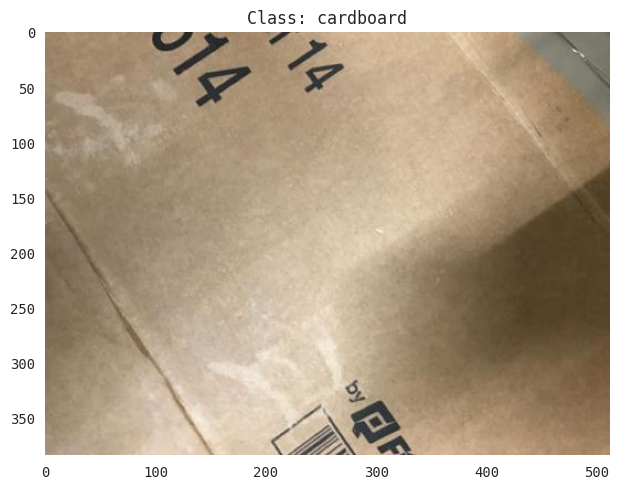

In [ ]:
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]
randomimage = keras.preprocessing.image.load_img(base_path + sample['filename'])

plt.imshow(randomimage)
plt.grid(visible=False)
plt.title(f"Class: {categories[sample['category']]}")

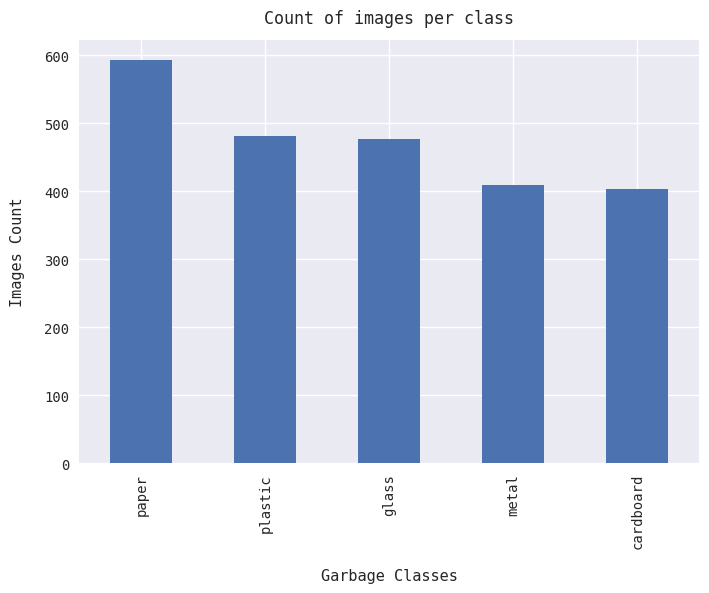

In [ ]:
df_vis = df.copy()
# Change the catgegories from numbers to names
df_vis['category'] = df_vis['category'].apply(lambda x:categories[x] )

df_vis['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [ ]:
mobilenetv2_layer = mobilenetv2.MobileNetV2(
    include_top = False,
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
    weights = 'imagenet'  # ../input/mobilenet-v2-keras-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
)

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False

# Create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_8 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
early_stop = EarlyStopping(
    patience=2,
    verbose=1,
    monitor='val_categorical_accuracy' ,
    mode='max',
    min_delta=0.001,
    restore_best_weights = True
)

callbacks = [early_stop]

print('Callbacks defined!')

Callbacks defined!


In [ ]:
# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = {}'.format(total_train), 'validate size = {}'.format(total_validate), 'test size = {}'.format(test_df.shape[0]), sep='\n')

train size = 1892
validate size = 331
test size = 142


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1892 validated image filenames belonging to 5 classes.


In [ ]:
validation_datagen = keras.preprocessing.image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 331 validated image filenames belonging to 5 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=int(np.ceil(total_validate / BATCH_SIZE)),
    steps_per_epoch=int(np.ceil(total_train / BATCH_SIZE))
    # callbacks=callbacks
)

Epoch 1/14


c:\Users\Bilgehan\anaconda3\envs\deepl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - categorical_accuracy: 0.5630 - loss: 1.0723 - val_categorical_accuracy: 0.8248 - val_loss: 0.4956
Epoch 2/14
237/237 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - categorical_accuracy: 0.8069 - loss: 0.5013 - val_categorical_accuracy: 0.8399 - val_loss: 0.3904
Epoch 3/14
237/237 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - categorical_accuracy: 0.8481 - loss: 0.4193 - val_categorical_accuracy: 0.8429 - val_loss: 0.4350
Epoch 4/14
237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - categorical_accuracy: 0.8335 - loss: 0.4215 - val_categorical_accuracy: 0.8550 - val_loss: 0.3807
Epoch 5/14
237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - categorical_accuracy: 0.8702 - loss: 0.3505 - val_categorical_accuracy: 0.8731 - val_loss: 0.3527
Epoch 6/14
237/237 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - categorical_accuracy: 0.8858 - loss: 0.3216 - val_categorical_accuracy: 0.8369 - val_loss: 0.3997
Epoch 7/14
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - categorical_accuracy: 0.8799 -

In [ ]:
model.save_weights(r"C:\Users\Bilgehan\Desktop\Projects\torch-scratch\models\mobilenetv2.weights.h5")

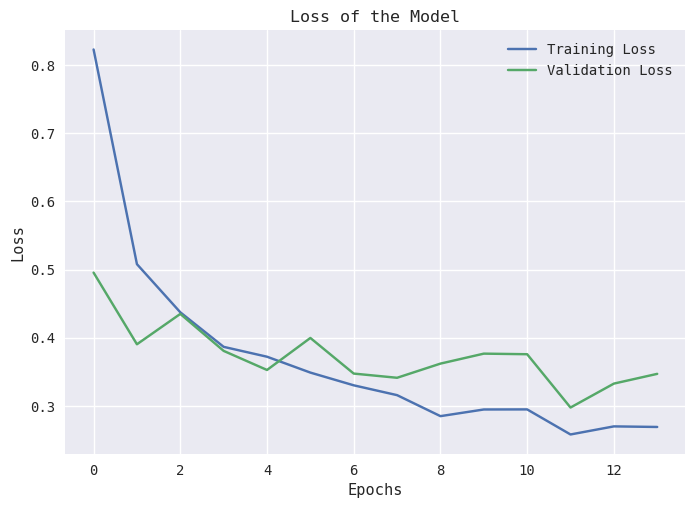

In [ ]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title('Loss of the Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

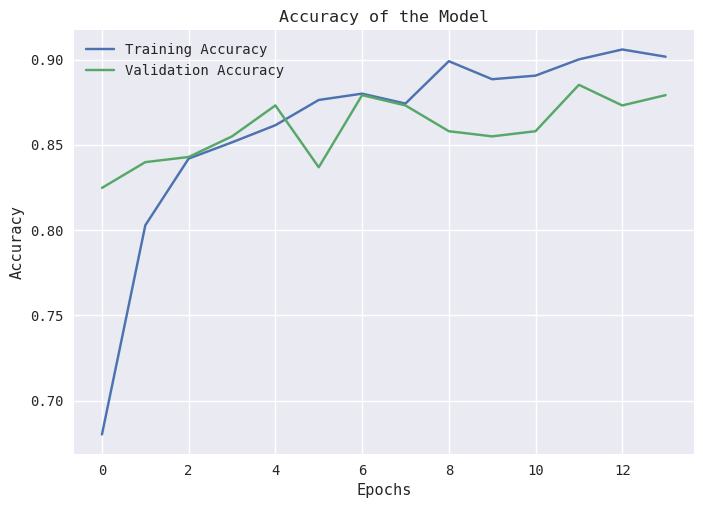

In [ ]:
plt.plot(history.history['categorical_accuracy'], label="Training Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Validation Accuracy")
plt.title('Accuracy of the Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 142 validated image filenames belonging to 5 classes.


In [ ]:
filenames = test_generator.filenames
n_samples = len(filenames)

preds = model.predict(test_generator, n_samples)

predicted_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
accuracy = accuracy_score(true_classes, predicted_classes)

print('Accuracy on the Test Set: ',  round((accuracy * 100), 2), '%')

c:\Users\Bilgehan\anaconda3\envs\deepl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Accuracy on the Test Set:  83.8 %


In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model
# will be made using the generator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic'}


In [ ]:
# get the model's predictions for the test set
preds = model.predict(test_generator, n_samples)

# Get the category with the highest predicted probability
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [ ]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00        18
       glass       1.00      0.60      0.75        35
       metal       0.71      1.00      0.83        34
       paper       0.93      0.84      0.89        32
     plastic       0.73      0.83      0.78        23

    accuracy                           0.84       142
   macro avg       0.87      0.85      0.85       142
weighted avg       0.87      0.84      0.84       142

